In [1]:
import QuantLib as ql

In [2]:
calc_date = ql.Date(14, 6, 2016)
ql.Settings.instance().evaluationDate = calc_date

In [3]:
dates = [ql.Date(14, 6, 2016), ql.Date(14, 9, 2016), ql.Date(14, 12, 2016), ql.Date(14, 6, 2017), 
         ql.Date(14, 6, 2019), ql.Date(14, 6, 2021), ql.Date(15, 6, 2026), ql.Date(16, 6, 2031), ql.Date(16, 6, 2036), ql.Date(14, 6, 2046)]
yields = [0.000000, 0.006616, 0.007049, 0.007795,
          0.009599, 0.011203, 0.015068, 0.017583,
          0.018988, 0.020080]

day_count = ql.ActualActual()
calendar = ql.UnitedStates()
interpolation = ql.Linear()
compounding = ql.Compounded
compounding_frequency = ql.Annual

term_structure = ql.ZeroCurve(dates, yields, day_count, calendar, interpolation, compounding, compounding_frequency)
ts_handle = ql.YieldTermStructureHandle(term_structure)

In [4]:
start_date = ql.Date(14, 6, 2016)
end_date = ql.Date(14, 6, 2026)
period = ql.Period(3, ql.Months)
calendar = ql.UnitedStates()
buss_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False

schedule = ql.Schedule(start_date, end_date, period, calendar, buss_convention, buss_convention, rule, end_of_month)

In [5]:
ibor_index = ql.USDLibor(ql.Period(3, ql.Months), ts_handle)
ibor_index.addFixing(ql.Date(10, 6, 2016), 0.0065560)
ibor_log = ql.IborLeg([1000000], schedule, ibor_index)

In [6]:
strike = 0.02
cap = ql.Cap(ibor_log, [strike])

vols = ql.QuoteHandle(ql.SimpleQuote(0.547295))
engine = ql.BlackCapFloorEngine(ts_handle, vols)

cap.setPricingEngine(engine)
print(cap.NPV())

54369.85806286925


In [7]:
strikes = [0.01, 0.015, 0.02]
temp = list(range(1, 11)) + [12]
expiries = [ql.Period(i, ql.Years) for i in temp]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83],
        [46.65, 54.15, 61.47, 65.53, 66.28, 62.83, 64.42, 60.05, 58.71, 60.35, 55.91],
        [46.6, 52.65, 59.32, 62.05, 62.0, 58.09, 59.03, 55.0, 53.59, 54.74, 49.54]]
for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i] / 100.0

In [8]:
calendar = ql.UnitedStates()
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes, vols, daycount)

In [9]:
optionlet_surf = ql.OptionletStripper1(capfloor_vol, ibor_index, ql.nullDouble(), 1e-6, 100, ts_handle)
ovs_handle = ql.OptionletVolatilityStructureHandle(ql.StrippedOptionletAdapter(optionlet_surf))

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

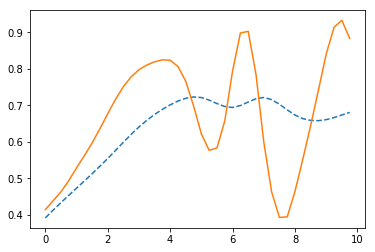

In [11]:
tenors = np.arange(0, 10, 0.25)
strike = 0.01
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
optionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

fig, ax = plt.subplots()
ax.plot(tenors, capfloor_vols, "--")
ax.plot(tenors, optionlet_vols, "-")

In [12]:
engine2 = ql.BlackCapFloorEngine(ts_handle, ovs_handle)
cap.setPricingEngine(engine2)
print(cap.NPV())

54384.928314950135


In [13]:
cap.impliedVolatility(cap.NPV(), ts_handle, 0.4)

0.5474438930928851